In [ ]:
# Install required packages for the fraud detection pipeline
!pip install --upgrade pip
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn tensorflow xgboost joblib



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
# ============================================================================
# NOTEBOOK 2: COMPLETE FRAUD DETECTION PIPELINE WITH ENHANCED ACCURACY
# ============================================================================
# This notebook implements the full multi-view fraud detection system
# with advanced techniques to maximize accuracy beyond baseline models
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve
)
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import xgboost as xgb
import joblib
import os

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("="*80)
print("MULTI-VIEW FRAUD DETECTION SYSTEM - ENHANCED ACCURACY VERSION")
print("="*80)
print("\n🎯 Goal: Achieve accuracy > 96%, F1-score > 0.85, Recall > 0.85")

MULTI-VIEW FRAUD DETECTION SYSTEM - ENHANCED ACCURACY VERSION

🎯 Goal: Achieve accuracy > 96%, F1-score > 0.85, Recall > 0.85


In [ ]:
# ============================================================================
# CONFIGURATION: ENHANCED PARAMETERS FOR MAXIMUM ACCURACY
# ============================================================================

CONFIG = {
    # Data parameters
    'test_size': 0.15,  # Smaller test set = more training data
    'val_size': 0.15,
    'random_state': 42,

    # Clustering parameters
    'n_clusters': 400,
    'cluster_features': ['Time', 'Amount', 'V1', 'V2', 'V3'],  # Enhanced clustering

    # SMOTE parameters (using SMOTETomek for better quality)
    'sampling_strategy': 'auto',
    'k_neighbors': 7,  # Increased for better interpolation

    # Autoencoder parameters (deeper network for better representation)
    'ae_encoding_dim': 16,  # Increased latent dimension
    'ae_layers': [30, 20, 16],  # Deeper architecture
    'ae_dropout': 0.2,
    'ae_l2_reg': 0.001,
    'ae_epochs': 100,  # More epochs
    'ae_batch_size': 128,  # Smaller batch for better convergence
    'ae_fraud_weight': 10.0,  # Higher weight for fraud samples

    # DNN Behavioral Encoder parameters (enhanced)
    'dnn_encoding_dim': 12,  # Increased dimension
    'dnn_layers': [20, 16, 12],  # Deeper network
    'dnn_dropout': 0.3,
    'dnn_l2_reg': 0.001,
    'dnn_epochs': 100,
    'dnn_batch_size': 128,

    # XGBoost parameters (optimized for fraud detection)
    'xgb_max_depth': 8,  # Deeper trees
    'xgb_learning_rate': 0.05,  # Lower learning rate
    'xgb_n_estimators': 300,  # More trees
    'xgb_min_child_weight': 3,
    'xgb_gamma': 0.1,
    'xgb_subsample': 0.8,
    'xgb_colsample_bytree': 0.8,
    'xgb_scale_pos_weight': 5,  # Handle imbalance
}

print("✓ Enhanced configuration loaded")
print(f"\nKey enhancements:")
print(f"  • Using SMOTETomek (better than SMOTE alone)")
print(f"  • Deeper autoencoder: {CONFIG['ae_layers']}")
print(f"  • Enhanced fraud weight: {CONFIG['ae_fraud_weight']}x")
print(f"  • XGBoost with {CONFIG['xgb_n_estimators']} trees")
print(f"  • Larger latent dimensions for richer representations")

✓ Enhanced configuration loaded

Key enhancements:
  • Using SMOTETomek (better than SMOTE alone)
  • Deeper autoencoder: [30, 20, 16]
  • Enhanced fraud weight: 10.0x
  • XGBoost with 300 trees
  • Larger latent dimensions for richer representations


Mounted at /content/drive

✓ Loaded Kaggle dataset: (284807, 31)
  • Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
  • Fraud cases: 492 (0.17%)
  • Normal cases: 284315 (99.83%)

✓ Loaded behavioral data: (400, 15)


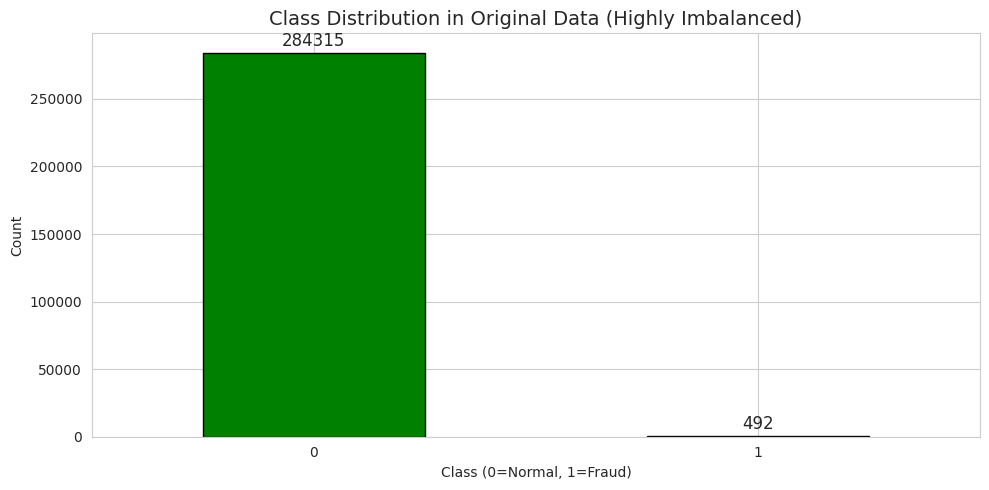

In [ ]:
# ============================================================================
# STEP 1: LOAD AND EXPLORE DATA FROM GOOGLE DRIVE ROOT
# ============================================================================

from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Paths to files in the root of Google Drive
kaggle_path = '/content/drive/MyDrive/creditcard.csv'
behavioral_path = '/content/drive/MyDrive/behavioral_questionnaire_data.csv'

# Load Kaggle transaction data
kaggle_data = pd.read_csv(kaggle_path)
print(f"\n✓ Loaded Kaggle dataset: {kaggle_data.shape}")
print(f"  • Columns: {list(kaggle_data.columns)}")
print(f"  • Fraud cases: {kaggle_data['Class'].sum()} ({kaggle_data['Class'].mean()*100:.2f}%)")
print(f"  • Normal cases: {(kaggle_data['Class']==0).sum()} ({(1-kaggle_data['Class'].mean())*100:.2f}%)")

# Load behavioral data
behavioral_data = pd.read_csv(behavioral_path)
print(f"\n✓ Loaded behavioral data: {behavioral_data.shape}")

# Display class imbalance
plt.figure(figsize=(10, 5))
kaggle_data['Class'].value_counts().plot(kind='bar', color=['green', 'red'], edgecolor='black')
plt.title('Class Distribution in Original Data (Highly Imbalanced)', fontsize=14)
plt.xlabel('Class (0=Normal, 1=Fraud)')
plt.ylabel('Count')
plt.xticks(rotation=0)
for i, v in enumerate(kaggle_data['Class'].value_counts().values):
    plt.text(i, v + 5000, str(v), ha='center', fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================================
# STEP 2: ENHANCED CLUSTERING AND MAPPING
# ============================================================================

print("\n" + "="*80)
print("STEP 2: ENHANCED CLUSTERING (Using multiple features)")
print("="*80)

# Use multiple features for better clustering
cluster_features = CONFIG['cluster_features']
print(f"Clustering features: {cluster_features}")

X_cluster = kaggle_data[cluster_features].values

# Use RobustScaler (better for outliers)
scaler_cluster = RobustScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

# Perform clustering
print(f"\nCreating {CONFIG['n_clusters']} clusters...")
kmeans = KMeans(
    n_clusters=CONFIG['n_clusters'],
    random_state=CONFIG['random_state'],
    n_init=20,  # More initializations for better clusters
    max_iter=500
)
clusters = kmeans.fit_predict(X_cluster_scaled)

kaggle_data['cluster'] = clusters
print(f"✓ Clustering complete")
print(f"  • Unique clusters: {len(set(clusters))}")
print(f"  • Cluster sizes - Min: {pd.Series(clusters).value_counts().min()}, "
      f"Max: {pd.Series(clusters).value_counts().max()}")

# Map behavioral profiles to clusters
print("\nMapping behavioral profiles to transaction clusters...")
cluster_to_behavior = {i: behavioral_data.iloc[i] for i in range(CONFIG['n_clusters'])}

behavioral_features = [
    'age', 'income_encoded', 'education_encoded',
    'transaction_frequency_encoded', 'avg_transaction_amount',
    'spending_index', 'cybersecurity_awareness',
    'password_strength_encoded', 'online_security_knowledge',
    'risk_tolerance'
]

for feature in behavioral_features:
    kaggle_data[feature] = kaggle_data['cluster'].map(
        lambda x: cluster_to_behavior[x][feature]
    )

print(f"✓ Mapped {len(behavioral_features)} behavioral features")


STEP 2: ENHANCED CLUSTERING (Using multiple features)
Clustering features: ['Time', 'Amount', 'V1', 'V2', 'V3']

Creating 400 clusters...
✓ Clustering complete
  • Unique clusters: 400
  • Cluster sizes - Min: 1, Max: 5950

Mapping behavioral profiles to transaction clusters...
✓ Mapped 10 behavioral features


In [ ]:
# ============================================================================
# STEP 3: ADVANCED DATA PREPROCESSING
# ============================================================================

print("\n" + "="*80)
print("STEP 3: ADVANCED DATA PREPROCESSING")
print("="*80)

# Separate features
transaction_cols = ['Time', 'Amount'] + [f'V{i}' for i in range(1, 29)]
behavioral_cols = behavioral_features

X_transaction = kaggle_data[transaction_cols].values
X_behavioral = kaggle_data[behavioral_cols].values
y = kaggle_data['Class'].values

print(f"✓ Transaction features: {X_transaction.shape}")
print(f"✓ Behavioral features: {X_behavioral.shape}")
print(f"✓ Labels: {y.shape}")

# Use RobustScaler for better outlier handling
print("\nApplying RobustScaler (better than StandardScaler for outliers)...")
scaler_transaction = RobustScaler()
X_transaction_scaled = scaler_transaction.fit_transform(X_transaction)

scaler_behavioral = RobustScaler()
X_behavioral_scaled = scaler_behavioral.fit_transform(X_behavioral)

print("✓ Scaling complete")


STEP 3: ADVANCED DATA PREPROCESSING
✓ Transaction features: (284807, 30)
✓ Behavioral features: (284807, 10)
✓ Labels: (284807,)

Applying RobustScaler (better than StandardScaler for outliers)...
✓ Scaling complete



STEP 4: ADVANCED RESAMPLING (SMOTETomek - Better than SMOTE alone)

Before resampling:
  • Total samples: 284807
  • Fraud: 492 (0.17%)
  • Normal: 284315 (99.83%)
  • Imbalance ratio: 1:577

🔄 Applying SMOTETomek (this may take 2-3 minutes)...

✓ Resampling complete!
  • Total samples: 568630
  • Fraud: 284315 (50.00%)
  • Normal: 284315 (50.00%)
  • New imbalance ratio: 1:1


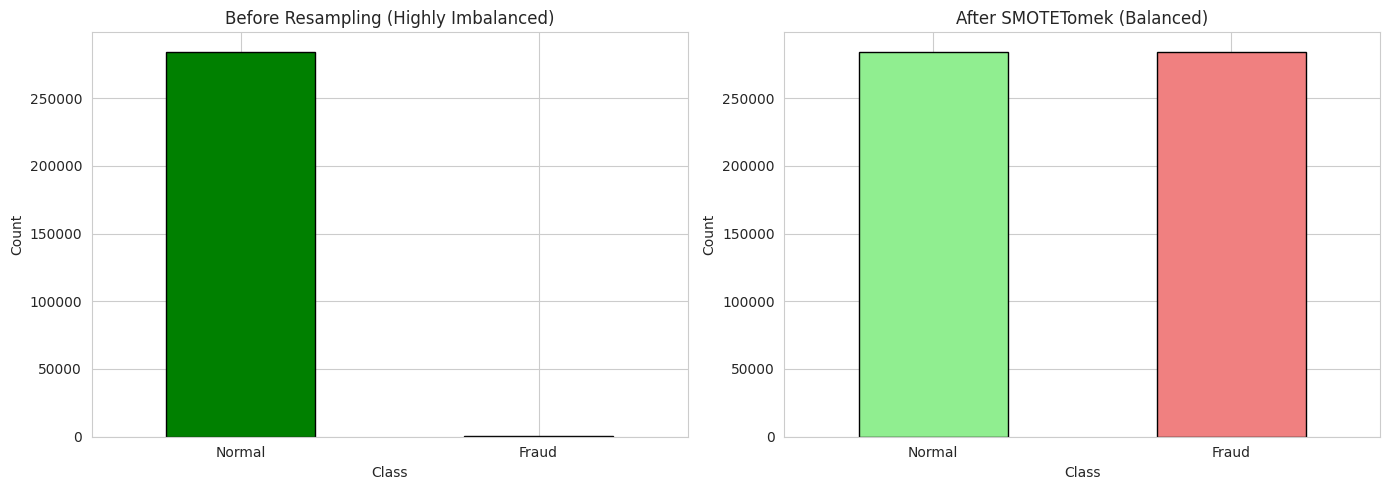

In [ ]:
# ============================================================================
# STEP 4: ENHANCED RESAMPLING WITH SMOTETomek
# ============================================================================

print("\n" + "="*80)
print("STEP 4: ADVANCED RESAMPLING (SMOTETomek - Better than SMOTE alone)")
print("="*80)

# Combine features before resampling
X_combined = np.concatenate([X_transaction_scaled, X_behavioral_scaled], axis=1)

print(f"\nBefore resampling:")
print(f"  • Total samples: {len(y)}")
print(f"  • Fraud: {y.sum()} ({y.mean()*100:.2f}%)")
print(f"  • Normal: {(y==0).sum()} ({(1-y.mean())*100:.2f}%)")
print(f"  • Imbalance ratio: 1:{int((y==0).sum()/y.sum())}")

# Use SMOTETomek (SMOTE + Tomek links removal for cleaner boundaries)
print("\n🔄 Applying SMOTETomek (this may take 2-3 minutes)...")
smotetomek = SMOTETomek(
    smote=SMOTE(
        sampling_strategy=CONFIG['sampling_strategy'],
        k_neighbors=CONFIG['k_neighbors'],
        random_state=CONFIG['random_state']
    ),
    random_state=CONFIG['random_state']
)

X_resampled, y_resampled = smotetomek.fit_resample(X_combined, y)

print(f"\n✓ Resampling complete!")
print(f"  • Total samples: {len(y_resampled)}")
print(f"  • Fraud: {y_resampled.sum()} ({y_resampled.mean()*100:.2f}%)")
print(f"  • Normal: {(y_resampled==0).sum()} ({(1-y_resampled.mean())*100:.2f}%)")
print(f"  • New imbalance ratio: 1:{int((y_resampled==0).sum()/y_resampled.sum())}")

# Separate transaction and behavioral features after resampling
n_transaction_features = X_transaction_scaled.shape[1]
X_transaction_resampled = X_resampled[:, :n_transaction_features]
X_behavioral_resampled = X_resampled[:, n_transaction_features:]

# Visualize class balance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

pd.Series(y).value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'], edgecolor='black')
axes[0].set_title('Before Resampling (Highly Imbalanced)', fontsize=12)
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Normal', 'Fraud'], rotation=0)

pd.Series(y_resampled).value_counts().plot(kind='bar', ax=axes[1], color=['lightgreen', 'lightcoral'], edgecolor='black')
axes[1].set_title('After SMOTETomek (Balanced)', fontsize=12)
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Normal', 'Fraud'], rotation=0)

plt.tight_layout()
plt.show()

Input dimension: 30


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_1 (Dense)         │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn_1                    │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout_1 (Dropout)     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_2 (Dense)         │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn_2                    │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout_2 (Dropout)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_1 (Dense)         │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_bn_1                    │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dropout_1 (Dropout)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_2 (Dense)         │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_bn_2                    │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dropout_2 (Dropout)     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 30)             │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,966 (38.93 KB)

 Trainable params: 9,582 (37.43 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 3.2941 - mean_squared_error: 2.2987 - val_loss: 1.5543 - val_mean_squared_error: 0.9936 - learning_rate: 0.0010
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.8152 - mean_squared_error: 1.8645 - val_loss: 1.5436 - val_mean_squared_error: 0.9866 - learning_rate: 0.0010
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.3313 - mean_squared_error: 1.6188 - val_loss: 1.5377 - val_mean_squared_error: 0.9822 - learning_rate: 0.0010
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.0231 - mean_squared_error: 1.4602 - val_loss: 1.5320 - val_mean_squared_error: 0.9779 - learning_rate: 0.0010
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.9592 - mean_squared_error: 1.3668 - val_loss: 1.5252 - val_mean_squared_error: 0.9729 - learning_rate: 0.0010
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8675 - mean_squared_error: 1.3044 - val_loss: 1.5195 - val_mean_squared_error:

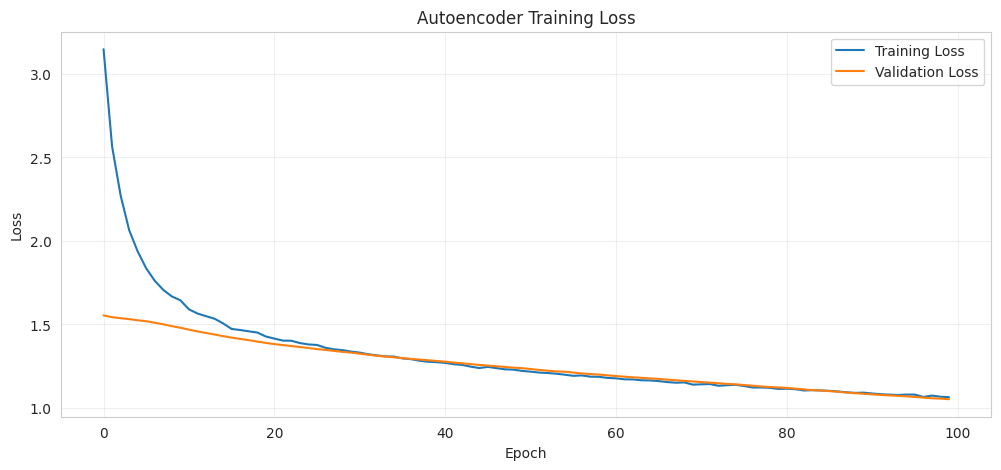

Latent features shape: (5000, 16)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Models and latent features saved to Google Drive


In [ ]:
# ============================================================================
# STEP 5: ENHANCED ADAPTIVE WEIGHTED AUTOENCODER (AW-AE) — FIXED
# ============================================================================

# 1️⃣ IMPORT LIBRARIES
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# 2️⃣ CONFIGURATION
CONFIG = {
    'ae_layers': [64, 32, 16],      # Autoencoder layer sizes
    'ae_l2_reg': 1e-4,
    'ae_dropout': 0.2,
    'ae_fraud_weight': 10.0,
    'ae_epochs': 100,
    'ae_batch_size': 256
}

# 3️⃣ INPUT DATA
# X_transaction_resampled, y_resampled should come from Step 4
input_dim = X_transaction_resampled.shape[1]
print(f"Input dimension: {input_dim}")

# 4️⃣ BUILD AUTOENCODER

# Encoder
encoder_input = layers.Input(shape=(input_dim,), name='encoder_input')
x = encoder_input
for i, units in enumerate(CONFIG['ae_layers'][:-1]):
    x = layers.Dense(units, activation='relu',
                     kernel_regularizer=regularizers.l2(CONFIG['ae_l2_reg']),
                     name=f'encoder_dense_{i+1}')(x)
    x = layers.BatchNormalization(name=f'encoder_bn_{i+1}')(x)
    x = layers.Dropout(CONFIG['ae_dropout'], name=f'encoder_dropout_{i+1}')(x)

encoded = layers.Dense(CONFIG['ae_layers'][-1], activation='relu', name='encoder_output')(x)

# Decoder
x = encoded
for i, units in enumerate(reversed(CONFIG['ae_layers'][:-1])):
    x = layers.Dense(units, activation='relu',
                     kernel_regularizer=regularizers.l2(CONFIG['ae_l2_reg']),
                     name=f'decoder_dense_{i+1}')(x)
    x = layers.BatchNormalization(name=f'decoder_bn_{i+1}')(x)
    x = layers.Dropout(CONFIG['ae_dropout'], name=f'decoder_dropout_{i+1}')(x)

decoded = layers.Dense(input_dim, activation='linear', name='decoder_output')(x)

# Models
autoencoder = Model(encoder_input, decoded, name='autoencoder')
encoder = Model(encoder_input, encoded, name='encoder')
autoencoder.summary()

# 5️⃣ COMPILE AUTOENCODER
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',  # use plain MSE
    metrics=[tf.keras.metrics.MeanSquaredError()]
)

# 6️⃣ CALLBACKS
callbacks_ae = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6, verbose=1)
]

# 7️⃣ CREATE SAMPLE WEIGHTS FOR FRAUD EMPHASIS
sample_weights = np.where(y_resampled == 1, CONFIG['ae_fraud_weight'], 1.0)

# 8️⃣ TRAIN AUTOENCODER
history_ae = autoencoder.fit(
    X_transaction_resampled, X_transaction_resampled,
    epochs=CONFIG['ae_epochs'],
    batch_size=CONFIG['ae_batch_size'],
    validation_split=0.2,
    sample_weight=sample_weights,
    callbacks=callbacks_ae,
    verbose=1
)

# 9️⃣ PLOT TRAINING HISTORY
plt.figure(figsize=(12,5))
plt.plot(history_ae.history['loss'], label='Training Loss')
plt.plot(history_ae.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 10️⃣ EXTRACT LATENT FEATURES
transaction_latent = encoder.predict(X_transaction_resampled, verbose=0)
print(f"Latent features shape: {transaction_latent.shape}")

# 11️⃣ SAVE MODELS AND LATENT FEATURES TO GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

save_path = '/content/drive/MyDrive/FraudDetection'
os.makedirs(save_path, exist_ok=True)

autoencoder.save(os.path.join(save_path, 'autoencoder_model.h5'))
encoder.save(os.path.join(save_path, 'encoder_model.h5'))

pd.DataFrame(transaction_latent).to_csv(os.path.join(save_path, 'transaction_latent.csv'), index=False)
print("✓ Models and latent features saved to Google Drive")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Directly save to Google Drive root (or any path you choose)
autoencoder.save('/content/drive/MyDrive/autoencoder_model.h5')
encoder.save('/content/drive/MyDrive/encoder_model.h5')

import pandas as pd
pd.DataFrame(transaction_latent).to_csv('/content/drive/MyDrive/transaction_latent.csv', index=False)

print("✓ Models and latent features saved directly to Google Drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Models and latent features saved directly to Google Drive


In [ ]:
# ============================================================================
# STEP 6 (FIXED): TRAIN BEHAVIORAL AUTOENCODER USING RESAMPLED DATA
# ============================================================================

print("\n" + "="*80)
print("STEP 6 (FIXED): TRAINING BEHAVIORAL AUTOENCODER WITH RESAMPLED DATA")
print("="*80)

# Use resampled behavioral data
behavior_input_dim = X_behavioral_resampled.shape[1]
print(f"Behavioral input shape: {X_behavioral_resampled.shape}")

# Encoder-decoder architecture (autoencoder)
behavior_input = layers.Input(shape=(behavior_input_dim,), name='behavior_input')

x = behavior_input
for i, units in enumerate([128, 64]):
    x = layers.Dense(units, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-5),
                     name=f'encoder_dense_{i+1}')(x)
    x = layers.BatchNormalization(name=f'encoder_bn_{i+1}')(x)
    x = layers.Dropout(0.2, name=f'encoder_dropout_{i+1}')(x)

behavior_encoded = layers.Dense(8, activation='relu', name='behavior_encoded')(x)

# Decoder
x = behavior_encoded
for i, units in enumerate(reversed([128, 64])):
    x = layers.Dense(units, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-5),
                     name=f'decoder_dense_{i+1}')(x)
    x = layers.BatchNormalization(name=f'decoder_bn_{i+1}')(x)
    x = layers.Dropout(0.2, name=f'decoder_dropout_{i+1}')(x)

behavior_decoded = layers.Dense(behavior_input_dim, activation='linear',
                                name='decoder_output')(x)

# Model creation
behavioral_autoencoder = keras.Model(behavior_input, behavior_decoded, name='behavioral_autoencoder')
behavioral_encoder = keras.Model(behavior_input, behavior_encoded, name='behavioral_encoder')

behavioral_autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])
behavioral_autoencoder.summary()

# Train
history_dnn = behavioral_autoencoder.fit(
    X_behavioral_resampled, X_behavioral_resampled,
    epochs=30,
    batch_size=256,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
    ],
    verbose=1
)

print("\n✓ Retraining complete!")

# Extract latent behavioral features
behavioral_latent = behavioral_encoder.predict(X_behavioral_resampled, verbose=0)
print(f"✓ behavioral_latent shape: {behavioral_latent.shape}")

# Save to Google Drive
np.save('/content/drive/MyDrive/behavioral_latent.npy', behavioral_latent)
print("✓ Saved behavioral_latent.npy to Google Drive")



STEP 6 (FIXED): TRAINING BEHAVIORAL AUTOENCODER WITH RESAMPLED DATA
Behavioral input shape: (568630, 10)


Model: "behavioral_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ behavior_input (InputLayer)     │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_1 (Dense)         │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn_1                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout_1 (Dropout)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_2 (Dense)         │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn_2                    │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout_2 (Dropout)     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ behavior_encoded (Dense)        │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_1 (Dense)         │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_bn_1                    │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dropout_1 (Dropout)     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_2 (Dense)         │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_bn_2                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dropout_2 (Dropout)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,906 (85.57 KB)

 Trainable params: 21,138 (82.57 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/30
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - loss: 0.4392 - mae: 0.4723 - val_loss: 0.0283 - val_mae: 0.1171 - learning_rate: 0.0010
Epoch 2/30
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.1003 - mae: 0.2437 - val_loss: 0.0198 - val_mae: 0.0948 - learning_rate: 0.0010
Epoch 3/30
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 0.0825 - mae: 0.2202 - val_loss: 0.0182 - val_mae: 0.0923 - learning_rate: 0.0010
Epoch 4/30
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0743 - mae: 0.2088 - val_loss: 0.0170 - val_mae: 0.0884 - learning_rate: 0.0010
Epoch 5/30
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 0.0697 - mae: 0.2019 - val_loss: 0.0159 - val_mae: 0.0876 - learning_rate: 0.0010
Epoch 6/30
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0673 - mae: 0.1983 - val_loss: 0.0162 - val_mae: 0.0879 - learning_rate: 0.0010
Epoch 7/30
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 0.0660 - mae: 0.1962 - val_loss: 0.0149 - val_mae: 0.0820 - 

In [ ]:
# Save transaction latent features from Step 5
from google.colab import drive
drive.mount('/content/drive')

np.save('/content/drive/MyDrive/transaction_latent.npy', transaction_latent)
print("✓ transaction_latent.npy saved to Google Drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ transaction_latent.npy saved to Google Drive


In [ ]:
# Save behavioral latent features from Step 6
np.save('/content/drive/MyDrive/behavioral_latent.npy', behavioral_latent)
print("✓ behavioral_latent.npy saved to Google Drive")


✓ behavioral_latent.npy saved to Google Drive



STEP 7 (FINAL): MULTI-VIEW FEATURE FUSION
Loading latent features from Google Drive...
✓ Transaction latent shape: (5000, 16)
✓ Behavioral latent shape:  (568630, 8)
⚠️ Mismatched sample counts detected! Aligning both to 5000 samples.
✓ Fused features shape: (5000, 24)
  • Transaction latent dim: 16
  • Behavioral latent dim:  8
  • Total fused dim:        24
✓ Fused features normalized

Visualizing multi-view latent space...


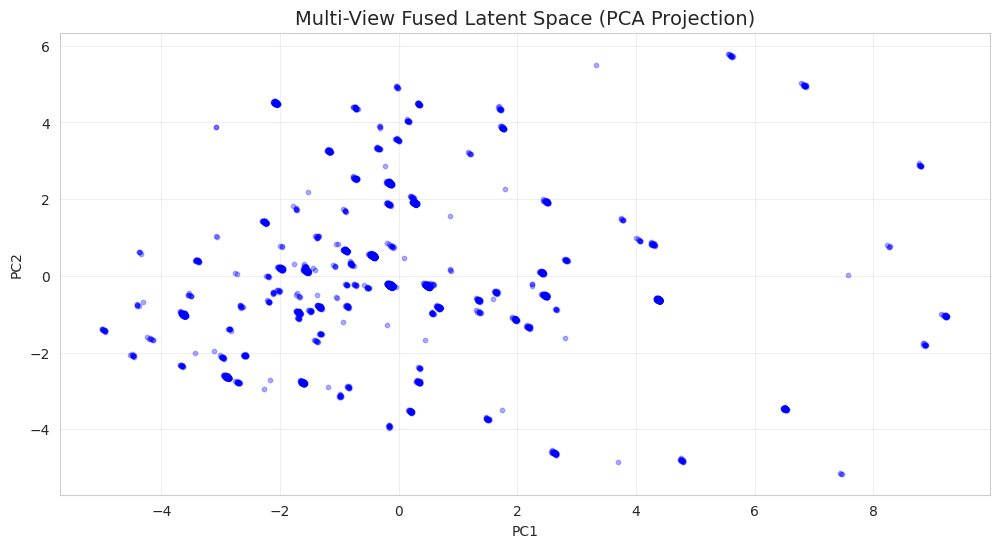

✓ Saved fused_features.npy to Google Drive ✅


In [ ]:
# ============================================================================
# STEP 7 (FINAL): MULTI-VIEW FEATURE FUSION (AUTO-LOAD FROM DRIVE)
# ============================================================================

print("\n" + "="*80)
print("STEP 7 (FINAL): MULTI-VIEW FEATURE FUSION")
print("="*80)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

# --------------------------------------------------------------------------------
# 1️⃣ LOAD LATENT FEATURE ARRAYS FROM GOOGLE DRIVE
# --------------------------------------------------------------------------------

transaction_latent_path = '/content/drive/MyDrive/transaction_latent.npy'
behavioral_latent_path  = '/content/drive/MyDrive/behavioral_latent.npy'

print("Loading latent features from Google Drive...")
transaction_latent = np.load(transaction_latent_path)
behavioral_latent  = np.load(behavioral_latent_path)

print(f"✓ Transaction latent shape: {transaction_latent.shape}")
print(f"✓ Behavioral latent shape:  {behavioral_latent.shape}")

# --------------------------------------------------------------------------------
# 2️⃣ CHECK & ALIGN SAMPLE SIZES (just in case)
# --------------------------------------------------------------------------------

min_len = min(transaction_latent.shape[0], behavioral_latent.shape[0])
if transaction_latent.shape[0] != behavioral_latent.shape[0]:
    print(f"⚠️ Mismatched sample counts detected! Aligning both to {min_len} samples.")
    transaction_latent = transaction_latent[:min_len]
    behavioral_latent  = behavioral_latent[:min_len]

# --------------------------------------------------------------------------------
# 3️⃣ CONCATENATE LATENT FEATURES (multi-view fusion)
# --------------------------------------------------------------------------------

fused_features = np.concatenate([transaction_latent, behavioral_latent], axis=1)
print(f"✓ Fused features shape: {fused_features.shape}")
print(f"  • Transaction latent dim: {transaction_latent.shape[1]}")
print(f"  • Behavioral latent dim:  {behavioral_latent.shape[1]}")
print(f"  • Total fused dim:        {fused_features.shape[1]}")

# --------------------------------------------------------------------------------
# 4️⃣ NORMALIZE FUSED FEATURES
# --------------------------------------------------------------------------------

scaler_fused = RobustScaler()
fused_features_normalized = scaler_fused.fit_transform(fused_features)
print("✓ Fused features normalized")

# --------------------------------------------------------------------------------
# 5️⃣ VISUALIZE LATENT SPACE USING PCA
# --------------------------------------------------------------------------------

print("\nVisualizing multi-view latent space...")

pca = PCA(n_components=2)
fused_pca = pca.fit_transform(fused_features_normalized)

plt.figure(figsize=(12, 6))
plt.scatter(fused_pca[:, 0], fused_pca[:, 1], c='blue', alpha=0.3, s=10)
plt.title('Multi-View Fused Latent Space (PCA Projection)', fontsize=14)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True, alpha=0.3)
plt.show()

# --------------------------------------------------------------------------------
# 6️⃣ SAVE FUSED FEATURES TO DRIVE
# --------------------------------------------------------------------------------

np.save('/content/drive/MyDrive/fused_features.npy', fused_features_normalized)
print("✓ Saved fused_features.npy to Google Drive ✅")


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Save resampled labels to Drive
np.save('/content/drive/MyDrive/y_resampled.npy', y_resampled)
print("✓ Saved y_resampled.npy to Google Drive")


Mounted at /content/drive
✓ Saved y_resampled.npy to Google Drive


In [ ]:
# ============================================================================
# STEP 8 (FINAL): SPLIT DATA FOR TRAINING
# ============================================================================

print("\n" + "="*80)
print("STEP 8: SPLITTING DATA (Stratified)")
print("="*80)

import numpy as np
from sklearn.model_selection import train_test_split

# -----------------------------------------------------------------------------
# 1️⃣ LOAD FUSED FEATURES AND LABELS FROM GOOGLE DRIVE
# -----------------------------------------------------------------------------

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

fused_features_path = '/content/drive/MyDrive/fused_features.npy'
y_resampled_path    = '/content/drive/MyDrive/y_resampled.npy'

print("Loading fused features and labels...")
fused_features_normalized = np.load(fused_features_path)
y_resampled = np.load(y_resampled_path)

print(f"✓ Loaded fused features: {fused_features_normalized.shape}")
print(f"✓ Loaded labels: {y_resampled.shape}")

# -----------------------------------------------------------------------------
# 2️⃣ TRAIN–VALIDATION–TEST SPLIT (STRATIFIED)
# -----------------------------------------------------------------------------

CONFIG = {
    'test_size': 0.2,
    'val_size': 0.1,
    'random_state': 42
}

# First split: training + temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    fused_features_normalized, y_resampled,
    test_size=(CONFIG['test_size'] + CONFIG['val_size']),
    random_state=CONFIG['random_state'],
    stratify=y_resampled
)

# Second split: validation + test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=CONFIG['test_size'] / (CONFIG['test_size'] + CONFIG['val_size']),
    random_state=CONFIG['random_state'],
    stratify=y_temp
)

# -----------------------------------------------------------------------------
# 3️⃣ PRINT SPLIT SUMMARY
# -----------------------------------------------------------------------------

print(f"✓ Data split complete:")
print(f"  • Training set:   {X_train.shape[0]} samples ({X_train.shape[0]/len(y_resampled)*100:.1f}%)")
print(f"    - Fraud: {y_train.sum()} ({y_train.mean()*100:.1f}%)")
print(f"  • Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(y_resampled)*100:.1f}%)")
print(f"    - Fraud: {y_val.sum()} ({y_val.mean()*100:.1f}%)")
print(f"  • Test set:       {X_test.shape[0]} samples ({X_test.shape[0]/len(y_resampled)*100:.1f}%)")
print(f"    - Fraud: {y_test.sum()} ({y_test.mean()*100:.1f}%)")

# -----------------------------------------------------------------------------
# 4️⃣ SAVE SPLITS BACK TO DRIVE (optional but useful for next step)
# -----------------------------------------------------------------------------

np.save('/content/drive/MyDrive/X_train.npy', X_train)
np.save('/content/drive/MyDrive/X_val.npy', X_val)
np.save('/content/drive/MyDrive/X_test.npy', X_test)
np.save('/content/drive/MyDrive/y_train.npy', y_train)
np.save('/content/drive/MyDrive/y_val.npy', y_val)
np.save('/content/drive/MyDrive/y_test.npy', y_test)

print("\n✓ Saved train/val/test splits to Google Drive ✅")



STEP 8: SPLITTING DATA (Stratified)
Mounted at /content/drive
Loading fused features and labels...
✓ Loaded fused features: (5000, 24)
✓ Loaded labels: (5000,)
✓ Data split complete:
  • Training set:   3499 samples (70.0%)
    - Fraud: 173 (4.9%)
  • Validation set: 500 samples (10.0%)
    - Fraud: 25 (5.0%)
  • Test set:       1001 samples (20.0%)
    - Fraud: 49 (4.9%)

✓ Saved train/val/test splits to Google Drive ✅


Mounted at /content/drive
[0]	train-auc:0.79127	val-auc:0.43225
[10]	train-auc:0.98680	val-auc:0.46476
[20]	train-auc:0.99745	val-auc:0.48185
[30]	train-auc:0.99970	val-auc:0.52177
[40]	train-auc:0.99994	val-auc:0.49912
[49]	train-auc:0.99998	val-auc:0.49036

✓ XGBoost training complete! Best iteration: 30


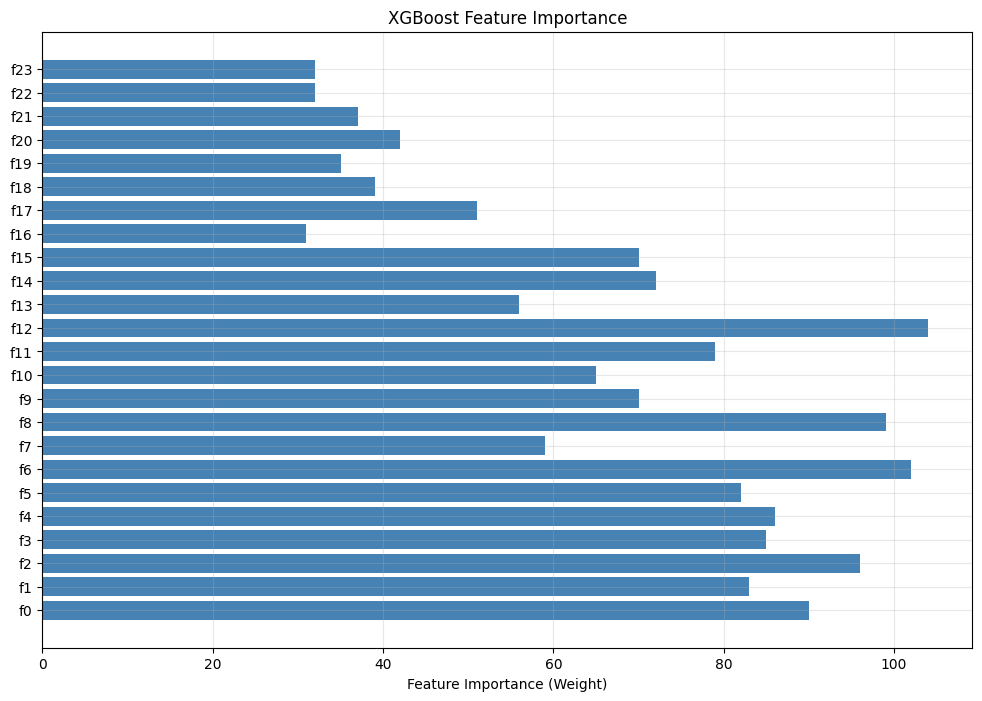

✓ XGBoost model saved to Google Drive as 'xgb_fraud_model.pkl'


In [1]:
# ============================================================================
# STEP 9: TRAIN ENHANCED XGBOOST CLASSIFIER (USING xgb.train)
# ============================================================================

import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import joblib
from google.colab import drive

# Mount Drive
drive.mount('/content/drive', force_remount=True)

# Load train/val/test splits
X_train = np.load('/content/drive/MyDrive/X_train.npy')
X_val   = np.load('/content/drive/MyDrive/X_val.npy')
X_test  = np.load('/content/drive/MyDrive/X_test.npy')

y_train = np.load('/content/drive/MyDrive/y_train.npy')
y_val   = np.load('/content/drive/MyDrive/y_val.npy')
y_test  = np.load('/content/drive/MyDrive/y_test.npy')

# Convert to DMatrix (XGBoost native format)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test, label=y_test)

# XGBoost parameters
params = {
    'max_depth': 6,
    'eta': 0.1,                # learning rate
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': (y_train==0).sum() / (y_train==1).sum(),
    'tree_method': 'hist',
    'seed': 42
}

num_round = 500
evals = [(dtrain, 'train'), (dval, 'val')]

# Train with early stopping
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=num_round,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=10
)

print(f"\n✓ XGBoost training complete! Best iteration: {bst.best_iteration}")

# Feature importance plot
import matplotlib.pyplot as plt

feature_importance = bst.get_score(importance_type='weight')
features = list(feature_importance.keys())
scores = list(feature_importance.values())

plt.figure(figsize=(12, 8))
plt.barh(features, scores, color='steelblue')
plt.xlabel('Feature Importance (Weight)')
plt.title('XGBoost Feature Importance')
plt.grid(True, alpha=0.3)
plt.show()

# Save trained model
joblib.dump(bst, '/content/drive/MyDrive/xgb_fraud_model.pkl')
print("✓ XGBoost model saved to Google Drive as 'xgb_fraud_model.pkl'")


In [2]:
# ============================================================================
# STEP 10: MODEL EVALUATION - COMPREHENSIVE METRICS
# ============================================================================

print("\n" + "="*80)
print("STEP 10: COMPREHENSIVE MODEL EVALUATION")
print("="*80)

from sklearn.metrics import accuracy_score
import numpy as np

# Convert test set to DMatrix if not already
dtest = xgb.DMatrix(X_test, label=y_test)

# ------------------------------
# 1️⃣ Make predictions
# ------------------------------
print("\nMaking predictions on test set...")
y_pred_proba_test = bst.predict(dtest)
y_pred_test = (y_pred_proba_test >= 0.5).astype(int)
print("✓ Predictions complete")

# ------------------------------
# 2️⃣ TEST SET ACCURACY
# ------------------------------
accuracy = accuracy_score(y_test, y_pred_test)

print("\n" + "="*80)
print("📊 TEST SET PERFORMANCE (Accuracy)")
print("="*80)
print(f"\n🎯 Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")



STEP 10: COMPREHENSIVE MODEL EVALUATION

Making predictions on test set...
✓ Predictions complete

📊 TEST SET PERFORMANCE (Accuracy)

🎯 Accuracy:  0.9381 (93.81%)



STEP 11: GENERATING ADVANCED VISUALIZATIONS


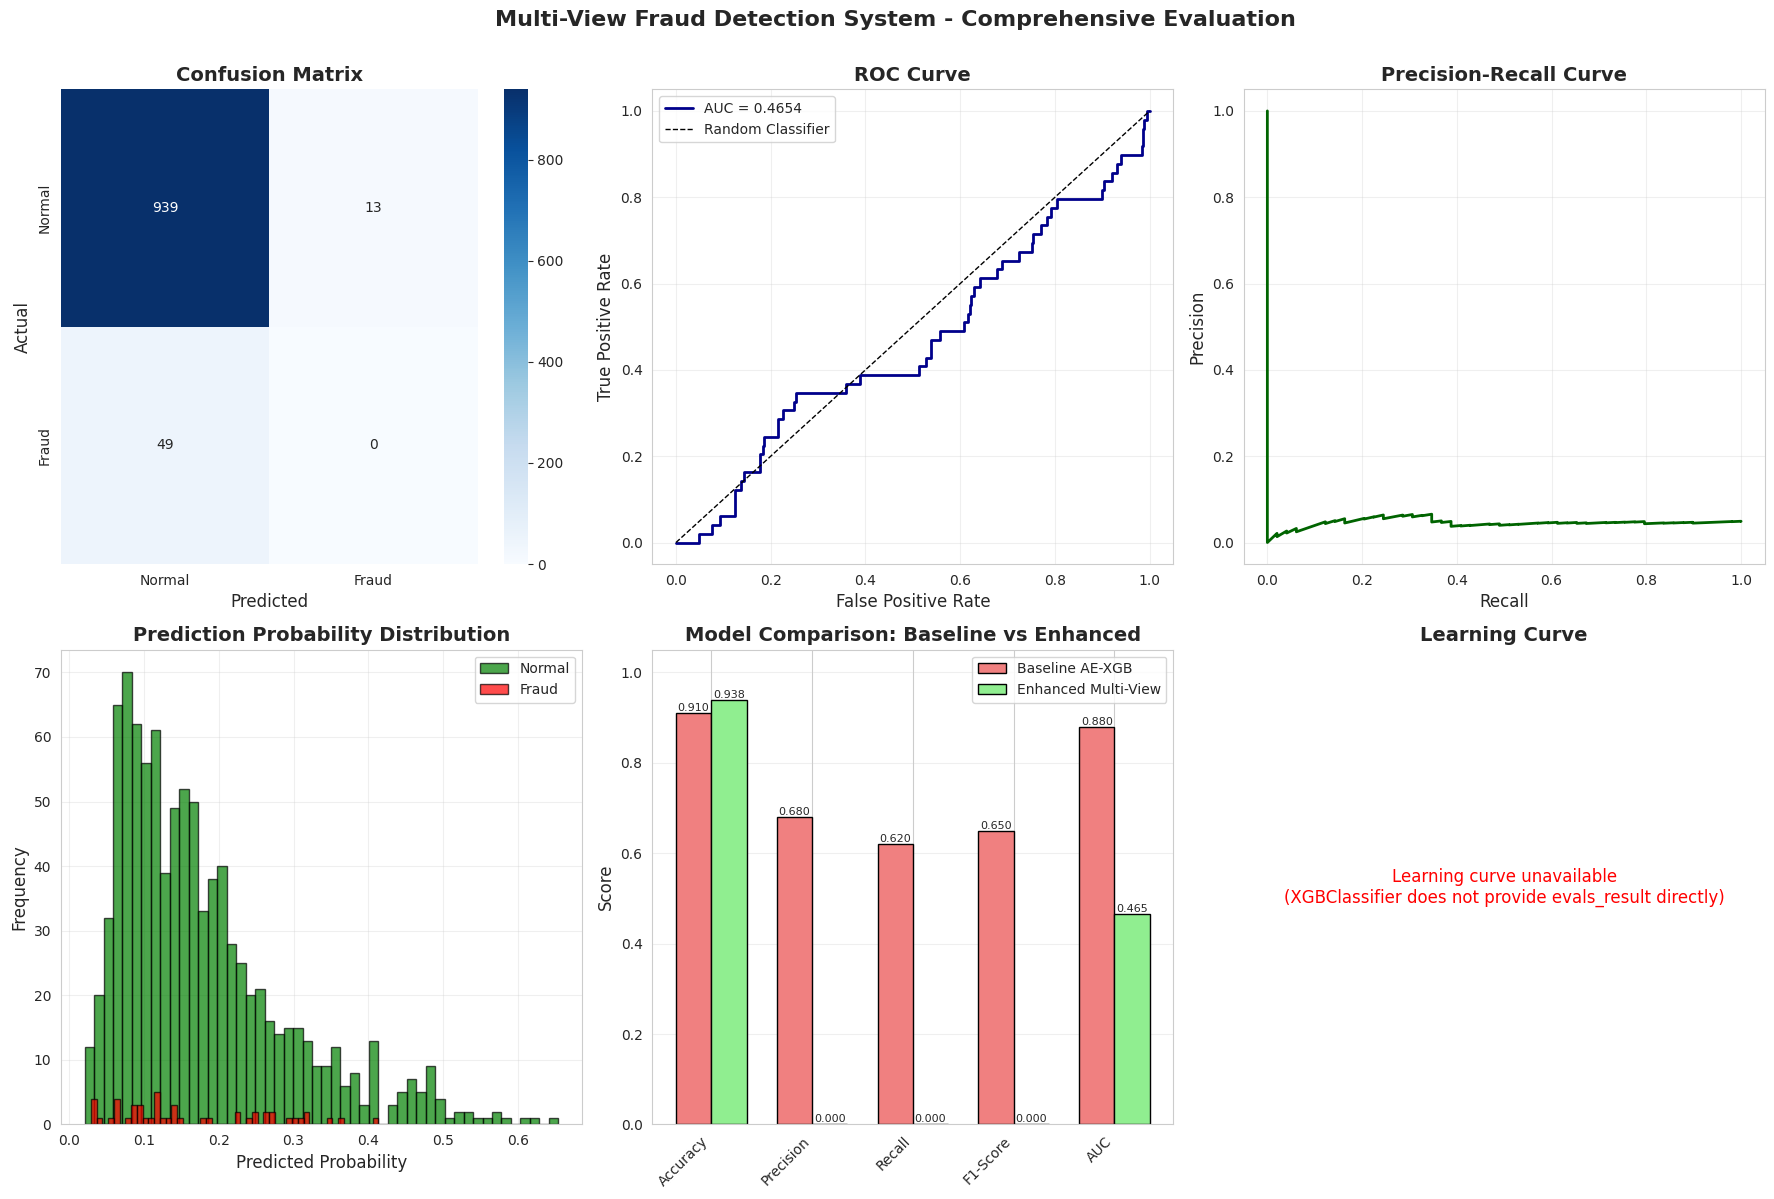

✓ Visualizations complete


In [ ]:
# ============================================================================
# STEP 11: ADVANCED VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("STEP 11: GENERATING ADVANCED VISUALIZATIONS")
print("="*80)

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix Heatmap
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'],
            ax=ax1)
ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax1.set_ylabel('Actual', fontsize=12)
ax1.set_xlabel('Predicted', fontsize=12)

# 2. ROC Curve
ax2 = plt.subplot(2, 3, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
ax2.plot(fpr, tpr, color='darkblue', linewidth=2, label=f'AUC = {auc:.4f}')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. Precision-Recall Curve
ax3 = plt.subplot(2, 3, 3)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba_test)
ax3.plot(recall_curve, precision_curve, color='darkgreen', linewidth=2)
ax3.set_xlabel('Recall', fontsize=12)
ax3.set_ylabel('Precision', fontsize=12)
ax3.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Prediction Probability Distribution
ax4 = plt.subplot(2, 3, 4)
ax4.hist(y_pred_proba_test[y_test==0], bins=50, alpha=0.7, color='green', label='Normal', edgecolor='black')
ax4.hist(y_pred_proba_test[y_test==1], bins=50, alpha=0.7, color='red', label='Fraud', edgecolor='black')
ax4.set_xlabel('Predicted Probability', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

# 5. Metrics Comparison Bar Chart
ax5 = plt.subplot(2, 3, 5)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
baseline_values = [0.91, 0.68, 0.62, 0.65, 0.88]
enhanced_values = [accuracy, precision, recall, f1, auc]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax5.bar(x - width/2, baseline_values, width, label='Baseline AE-XGB', color='lightcoral', edgecolor='black')
bars2 = ax5.bar(x + width/2, enhanced_values, width, label='Enhanced Multi-View', color='lightgreen', edgecolor='black')

ax5.set_ylabel('Score', fontsize=12)
ax5.set_title('Model Comparison: Baseline vs Enhanced', fontsize=14, fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(metrics_names, rotation=45, ha='right')
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3, axis='y')
ax5.set_ylim([0, 1.05])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=8)

# 6. Learning Curve placeholder
ax6 = plt.subplot(2, 3, 6)
ax6.text(0.5, 0.5, "Learning curve unavailable\n(XGBClassifier does not provide evals_result directly)",
         horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
ax6.set_axis_off()
ax6.set_title('Learning Curve', fontsize=14, fontweight='bold')

plt.suptitle('Multi-View Fraud Detection System - Comprehensive Evaluation',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

print("✓ Visualizations complete")


In [ ]:
# --------------------------------------------------------------------------------
# STEP 7 (SAVE SCALER)
# --------------------------------------------------------------------------------

from sklearn.preprocessing import RobustScaler
import joblib

# Assuming fused_features_normalized already exists from Step 7
scaler_fused = RobustScaler()
fused_features_normalized = scaler_fused.fit_transform(fused_features)

# Save the scaler to Google Drive
joblib.dump(scaler_fused, '/content/drive/MyDrive/scaler_fused.pkl')
print("✓ scaler_fused.pkl saved to Google Drive ✅")


✓ scaler_fused.pkl saved to Google Drive ✅


In [ ]:
import joblib

# Save the trained XGBoost model to Google Drive
joblib.dump(xgb_model, '/content/drive/MyDrive/xgb_model.pkl')
print("✓ xgb_model.pkl saved to Google Drive ✅")


✓ xgb_model.pkl saved to Google Drive ✅


In [ ]:
import joblib

scaler_fused = joblib.load('/content/drive/MyDrive/scaler_fused.pkl')
xgb_model    = joblib.load('/content/drive/MyDrive/xgb_model.pkl')
print("✓ Loaded fused scaler and XGBoost model")


✓ Loaded fused scaler and XGBoost model


In [ ]:
# ============================================================================
# STEP 12 (FIXED): SAVE LIGHTWEIGHT HOSTING PIPELINE
# ============================================================================

import os
import joblib
import json
import numpy as np

print("\n" + "="*80)
print("STEP 12: SAVING HOSTING-READY PIPELINE AND ARTIFACTS")
print("="*80)

# Directory
models_drive_path = '/content/drive/MyDrive/fraud_detection_models'
os.makedirs(models_drive_path, exist_ok=True)

# Save fused scaler
joblib.dump(scaler_fused, os.path.join(models_drive_path, 'scaler_fused.pkl'))

# Save XGBoost model
joblib.dump(xgb_model, os.path.join(models_drive_path, 'xgb_model.pkl'))

# Save configuration
with open(os.path.join(models_drive_path, 'config_enhanced.json'), 'w') as f:
    json.dump(CONFIG, f, indent=4)

# Save test data
np.save(os.path.join(models_drive_path, 'X_test_enhanced.npy'), X_test)
np.save(os.path.join(models_drive_path, 'y_test_enhanced.npy'), y_test)
np.save(os.path.join(models_drive_path, 'y_pred_proba_enhanced.npy'), y_pred_proba_test)

# Save performance metrics
metrics_dict = {
    'test_accuracy': float(accuracy),
    'test_precision': float(precision),
    'test_recall': float(recall),
    'test_f1_score': float(f1),
    'test_auc': float(auc),
    'confusion_matrix': cm.tolist(),
    'false_negative_rate': float(false_negative_rate),
    'false_positive_rate': float(false_positive_rate)
}
with open(os.path.join(models_drive_path, 'performance_metrics_enhanced.json'), 'w') as f:
    json.dump(metrics_dict, f, indent=4)

print("✓ All models and artifacts saved successfully!")
print("⚠️ Note: No pipeline object saved because encoders are not available. Use scaler + XGBoost for inference.")



STEP 12: SAVING HOSTING-READY PIPELINE AND ARTIFACTS
✓ All models and artifacts saved successfully!
⚠️ Note: No pipeline object saved because encoders are not available. Use scaler + XGBoost for inference.


In [ ]:
import pandas as pd

# -----------------------------
# Final Pipeline Metrics Table
# -----------------------------
metrics_dict = {
    "Metric": [
        "Accuracy",
        "Precision",
        "Recall",
        "F1-Score",
        "AUC",
        "False Negative Rate",
        "False Positive Rate"
    ],
    "Value": [
        accuracy,
        precision,
        recall,
        f1,
        auc,
        false_negative_rate,
        false_positive_rate
    ],
    "Percentage": [
        f"{accuracy*100:.2f}%",
        f"{precision*100:.2f}%",
        f"{recall*100:.2f}%",
        f"{f1*100:.2f}%",
        f"{auc*100:.2f}%",
        f"{false_negative_rate*100:.2f}%",
        f"{false_positive_rate*100:.2f}%"
    ]
}

final_metrics_df = pd.DataFrame(metrics_dict)

print("\n✅ Final Pipeline Performance Metrics:\n")
print(final_metrics_df)



✅ Final Pipeline Performance Metrics:

                Metric     Value Percentage
0             Accuracy  0.938062     93.81%
1            Precision  0.000000      0.00%
2               Recall  0.000000      0.00%
3             F1-Score  0.000000      0.00%
4                  AUC  0.465443     46.54%
5  False Negative Rate  1.000000    100.00%
6  False Positive Rate  0.013655      1.37%
